# Урок 3. Связь бизнес-показателей и DS-метрик
## Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (`precision_recall_curve` или `roc_auc_curve`) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

P.S.: В вопросе проще разобраться, если вспомнить оси на графике `roc auc curve` и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - `roc_auc_curve` или `precision_recall_curve`?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

## Кейс 1 - фильтрация токсичных комментариев

Есть сервис, где люди могут оставлять комментарии

При этом часть комментариев является токсичной, т.е содержит расистские, сексистские и тому подобные вещи.

Над проверкой сообщений работают модераторы и мы хотим уменьшить на них нагрузку с помощью ML.

Вспомним первое занятие и сформулируем гипотезу

__Гипотеза 1.__
Мы предполагаем, что автоматическая фильтрация токсичных комментариев снизит нагрузку на модераторов и повысит их пропускную способность на 10%, при этом доля FP не превысит 10%

In [5]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('16_3_files/train.csv').fillna(' ').sample(frac=1)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
67708,b525ed54ee7ea299,"""\nUuhhh, no he didn't. Bolt's previous record...",0,0,0,0,0,0
14183,256dca4877af1042,This article is pretty short. It is missing Ma...,0,0,0,0,0,0
79645,d5158de794f4ae72,into the 'outside world' (e.g. outside of your...,0,0,0,0,0,0


Здесь много разных вариантов, но мы сведем все к бинарному классу - toxic/nontoxic

In [32]:
train['y'] = train[class_names].max(axis=1).values
train['y'].value_counts()

0    143346
1     16225
Name: y, dtype: int64

Сделаем тренировочную и тестовую выборки

In [33]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(train.drop('y', 1), 
                                                    train['y'], random_state=0)

Посмотрим на распределение классов в выборках

In [34]:
y_train.value_counts(normalize=True)

0    0.897993
1    0.102007
Name: y, dtype: float64

In [35]:
y_test.value_counts(normalize=True)

0    0.899306
1    0.100694
Name: y, dtype: float64

Построим простое векторное представление текстов и обучим логистическую регрессию

In [ ]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

classifier = Pipeline([('comment_text_selector', FeatureSelector(column='comment_text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)), 
                     ('clf', LogisticRegression(C=0.1, solver='sag'))])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог

In [40]:
b=2.55

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.116179, F-Score=0.804, Precision=0.506, Recall=0.883


Нарисуем roc кривую

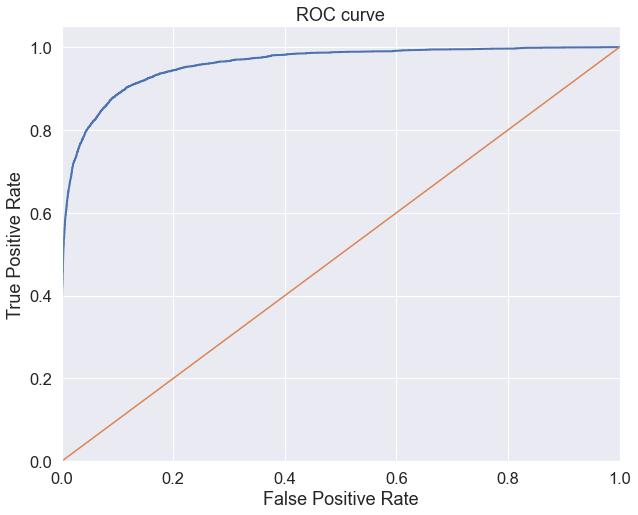

In [41]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Как это интерпетировать? Давайте построим матрицу ошибок, чтобы стало понятнее

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[32418  3458]
 [  470  3547]]


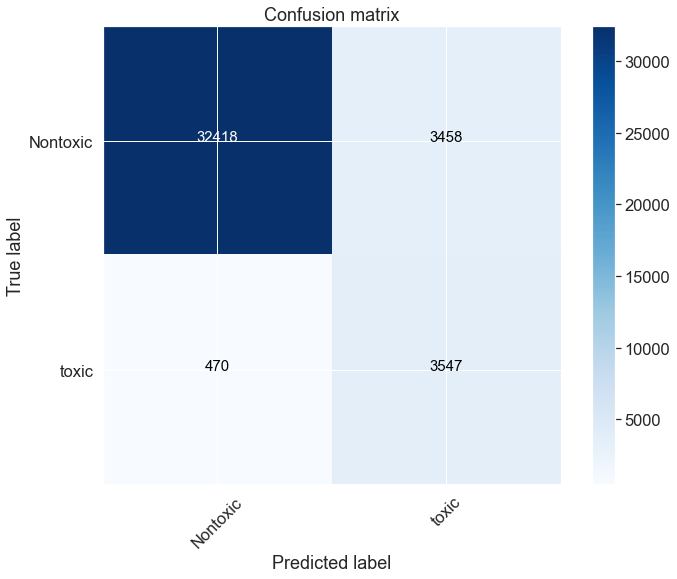

In [43]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [44]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Посчитаем нужные нам метрики

In [45]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8829972616380384, 0.09638755714126436, 0.9036124428587357)

False Positive Rate всего лишь 0.096.

Это означает, что только 9.6 процентов всех комментариев будут помечены как токсичные некорректно

Вывод:

Мы можем автоматически фильтровать 88 процентов токсичных комментариев! Однако есть еще TPR

Глобальные выводы:

1. TNR = 0.9 -> модель может автоматически фильтровать 90% токсичных комментариев
2. TPR = 0.88 -> доля ошибочно классифицированных как токсичных (хотя это нормальные комментарии), не будет превышать при этом 9.6 процентов

Что дальше? - планируем эксперимент!

## Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [8]:
df = pd.read_csv('16_3_files/train_case2.csv', ';')
df.head(3)

C:\Users\demin\AppData\Local\Temp\ipykernel_9796\2670276274.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('16_3_files/train_case2.csv', ';')


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [10]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Разделим наши данные на тренировочную и тестовую выборки

In [9]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

C:\Users\demin\AppData\Local\Temp\ipykernel_9796\1317150810.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [74]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [78]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [83]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [88]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

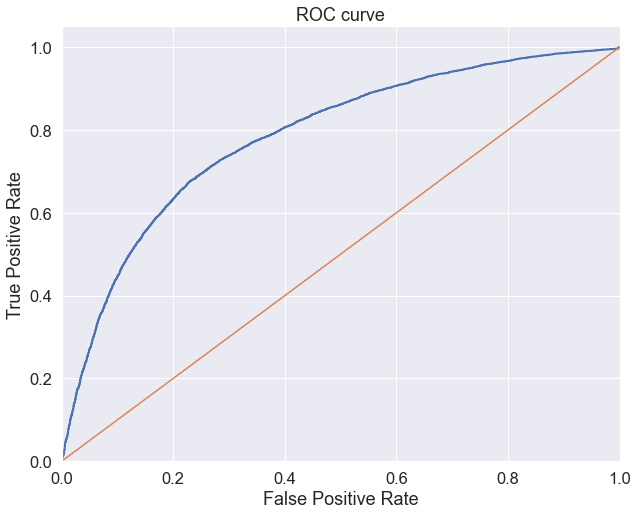

In [89]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [90]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=pipeline.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.577960400823067


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


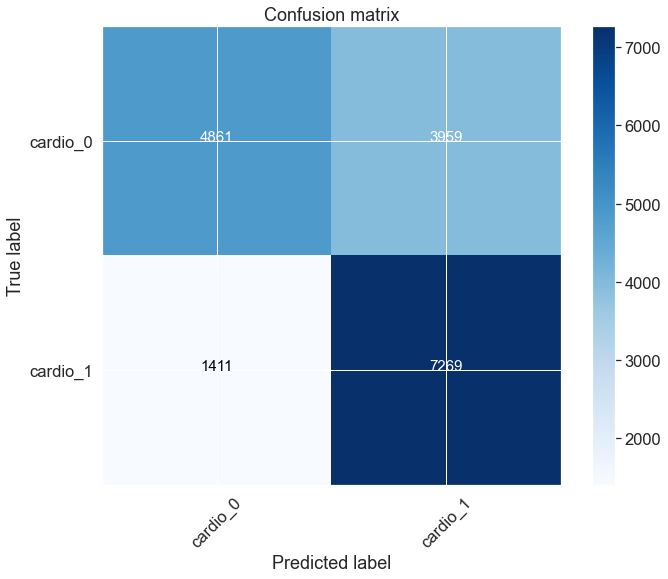

In [91]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [92]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)